In [23]:
import sys
sys.path.append('../..')
from torchvision.utils import make_grid
from torchvision.models.mobilenet import mobilenet_v2
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import torchvision
from DLBio.pytorch_helpers import get_device
import numpy as np
import matplotlib.pyplot as plt
import ds_ear_siamese
import transforms_data as td
from siamese_network_train import Training
from ContrastiveLossFunction import ContrastiveLoss
from torch import cuda
from NN_Siamese import SiameseNetwork

In [24]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [25]:
# Set Up All Configurations here
class Config():
    NN_SIAMESE = True
    dataset_dir = '../dataset_low_res/'
    # training_dir = "../data/ears/training/"
    # testing_dir = "../data/ears/testing/"
    train_batch_size = 32
    test_batch_size = 1
    vis_batch_size = 8
    num_workers = 3
    
    EPOCHS= 100
    LEARNINGRATE = 0.0005
    WEIGHT_DECAY = 1

In [26]:
# define indicies to split Data
N = len(ds_ear_siamese.get_dataset(data_path=Config.dataset_dir, transform_mode='size_only'))
print(N)
n_80 = int(round(.8*N))
n_70 = int(round(.7*N))
n_60 = int(round(.6*N))

rand_indices = np.random.permutation(N)
train_indices = rand_indices[:n_70]
test_indices = rand_indices[n_70:]

# definde data loader
# dl_train = ds_ear_siamese.get_dataloader(
train_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.train_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese', # TODO switch to another transform? 
    data_path=Config.dataset_dir
)

# dl_test = ds_ear_siamese.get_dataloader(
test_dataloader = ds_ear_siamese.get_dataloader(
    indices=test_indices,
    batch_size=Config.test_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

vis_dataloader = ds_ear_siamese.get_dataloader(
    indices=train_indices,
    batch_size=Config.vis_batch_size,
    num_workers=Config.num_workers,
    transform_mode='siamese',
    data_path=Config.dataset_dir
)

['alissa_buh', 'falco_len', 'gregor_spi', 'janna_qua', 'jesse_kru', 'johannes_boe', 'johannes_wie', 'konrad_von', 'mila_wol', 'nils_loo', 'sarah_feh', 'tim_moe']
847


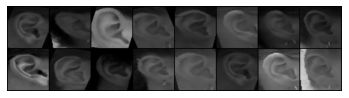

[[0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [27]:
# visualize some data....
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1]),0)
imshow(make_grid(concatenated))
print(example_batch[2].numpy())

In [28]:
# Definde Model and load to device
if Config.NN_SIAMESE == False:
    model = mobilenet_v2(pretrained=True)
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    model.classifier[1] = nn.Linear(in_features=model.classifier[1].in_features, out_features=5)

    layers = []
    for layer in model.features[0]:
        layers.append(layer)
    model.features[0][0] = nn.ReflectionPad2d(1)
    model.features[0][1] = layers[0]
    model.features[0][2] = layers[1]
    model.features[0].add_module('3', layers[2])
else:
    model = SiameseNetwork()


device = get_device()
print(device)
model.to(device)

contrastive_loss_siamese = ContrastiveLoss()
optimizer_siamese = torch.optim.Adam(model.parameters(),lr = Config.LEARNINGRATE)



cuda:0


Epoch number 0
 Current loss 1.3712382316589355

Epoch number 0
 Current loss 3.6533043384552

Epoch number 1
 Current loss 1.8036912679672241

Epoch number 1
 Current loss 1.5680932998657227

Epoch number 2
 Current loss 2.1222519874572754

Epoch number 2
 Current loss 1.5513689517974854

Epoch number 3
 Current loss 1.4157179594039917

Epoch number 3
 Current loss 1.7272844314575195

Epoch number 4
 Current loss 1.3580694198608398

Epoch number 4
 Current loss 1.232137680053711

Epoch number 5
 Current loss 1.1075421571731567

Epoch number 5
 Current loss 0.9782043695449829

Epoch number 6
 Current loss 1.2577515840530396

Epoch number 6
 Current loss 0.8722432255744934

Epoch number 7
 Current loss 0.9499040842056274

Epoch number 7
 Current loss 0.8726905584335327

Epoch number 8
 Current loss 0.9613968133926392

Epoch number 8
 Current loss 1.3550949096679688

Epoch number 9
 Current loss 0.7638480067253113

Epoch number 9
 Current loss 1.1822506189346313

Epoch number 10
 Current

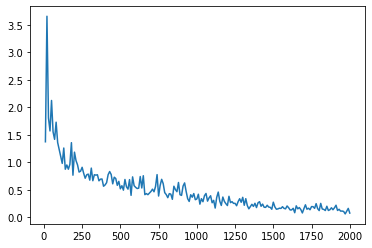

In [29]:
training = Training(model=model, optimizer=optimizer_siamese,train_dataloader=train_dataloader, 
                loss_contrastive=contrastive_loss_siamese, nn_Siamese=Config.NN_SIAMESE)

counter, loss_history = training(Config.EPOCHS)
show_plot(counter, loss_history)

In [30]:
if Config.NN_SIAMESE:
    def generate_output( img_in, img_in2):
        if cuda.is_available():
            return model(Variable(img_in).cuda(), Variable(img_in2).cuda())
        else:
            return model(Variable(img_in), Variable(img_in2))

else:
    def generate_output( img_in):
        if cuda.is_available():
            return model(Variable(img_in).cuda())
        else:
            return model(Variable(img_in))         

In [32]:
iter_batches = iter(test_dataloader)
accuracy_count = 0.0
matches = []
non_matches = []
for i in range(len(iter_batches)):
    # batch size schould be 1 to throw no errors in accessing the next(iter_batches) 
    img0, img1, label = next(iter_batches)
    # appends images to matches, if label is 0 (0 = same)
    ((matches, non_matches)[int(label)]).append( (img0,img1) )

# iterate through both lists and compare the distances of the current entries
for m, n in zip(matches, non_matches):
    # get the models output vectors for the images
    
    if Config.NN_SIAMESE:
        match_out1, match_out2 = generate_output(m[0], m[1])
        non_match_out1, non_match_out2 = generate_output(n[0], n[1])
    else:
        match_out1 = generate_output(m[0])
        match_out2 = generate_output(m[1])                 
        non_match_out1 = generate_output(n[0])
        non_match_out2 = generate_output(n[1])
        
    # positive-positive, positive-negative distance
    euclidean_distance_pp = F.pairwise_distance(match_out1, match_out2)
    euclidean_distance_pn = F.pairwise_distance(non_match_out1, non_match_out2)
    
    # format variables
    fmt_id = '{:<12}'
    fmt_eucl = '{:<.3f}'
    # increase accouracy count if p-p was lower than p-n
    if(euclidean_distance_pp < euclidean_distance_pn): accuracy_count += 1
    # print current stats
    print(fmt_id.format('pos-pos: '), fmt_eucl.format( euclidean_distance_pp.item()) )
    print(fmt_id.format('pos-neg: '),fmt_eucl.format( euclidean_distance_pn.item()) )
    print(fmt_id.format('Acc. count: '), '{:>.0f}'.format(accuracy_count), '\n')

# divide by the minimum length (zip function regulated the steps to the minimum)
print(fmt_id.format('Overall (estimated) accuracy: '), fmt_eucl.format(accuracy_count / min(len(matches), len(non_matches)) ), ' %')

pos-pos:     0.595
pos-neg:     1.292
Acc. count:  1 

pos-pos:     0.339
pos-neg:     1.610
Acc. count:  2 

pos-pos:     0.764
pos-neg:     1.746
Acc. count:  3 

pos-pos:     0.471
pos-neg:     2.892
Acc. count:  4 

pos-pos:     0.529
pos-neg:     1.523
Acc. count:  5 

pos-pos:     0.222
pos-neg:     1.761
Acc. count:  6 

pos-pos:     0.300
pos-neg:     0.992
Acc. count:  7 

pos-pos:     0.353
pos-neg:     1.826
Acc. count:  8 

pos-pos:     0.532
pos-neg:     1.730
Acc. count:  9 

pos-pos:     0.690
pos-neg:     0.973
Acc. count:  10 

pos-pos:     1.078
pos-neg:     1.635
Acc. count:  11 

pos-pos:     0.535
pos-neg:     1.586
Acc. count:  12 

pos-pos:     0.601
pos-neg:     1.762
Acc. count:  13 

pos-pos:     0.415
pos-neg:     1.794
Acc. count:  14 

pos-pos:     0.822
pos-neg:     0.342
Acc. count:  14 

pos-pos:     0.275
pos-neg:     2.310
Acc. count:  15 

pos-pos:     1.088
pos-neg:     1.147
Acc. count:  16 

pos-pos:     0.364
pos-neg:     1.484
Acc. count:  17 

p

In [ ]:
#model = torch.load('/Users/falcolentzsch/Develope/Bachelorthesis/Bachelorthesis/models/model.pt')

In [34]:
torch.save(model,'/nfshome/lentzsch/Documents/Bachelorarbeit/Bachelorthesis/models/model_NN_1.pt')